## Preparing the target distribution of the MCMC Algorithms

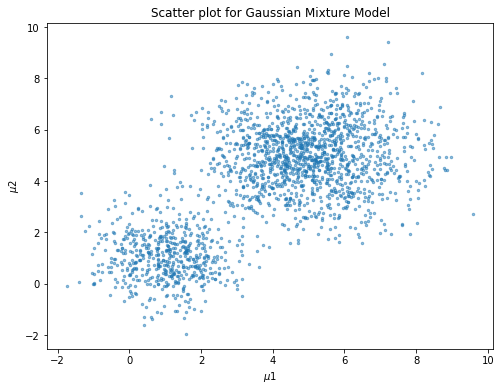

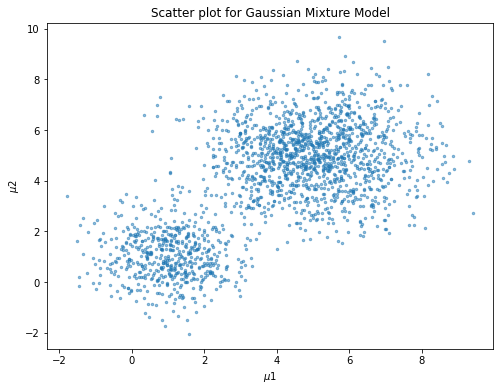

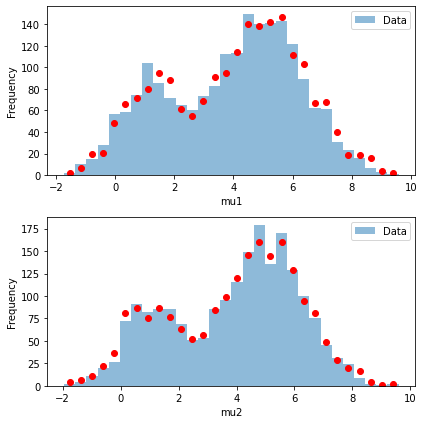

/Users/zhangdian/Documents/GitHub/MResMCMC2023/GMM_Likelihoods_1.py:314: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


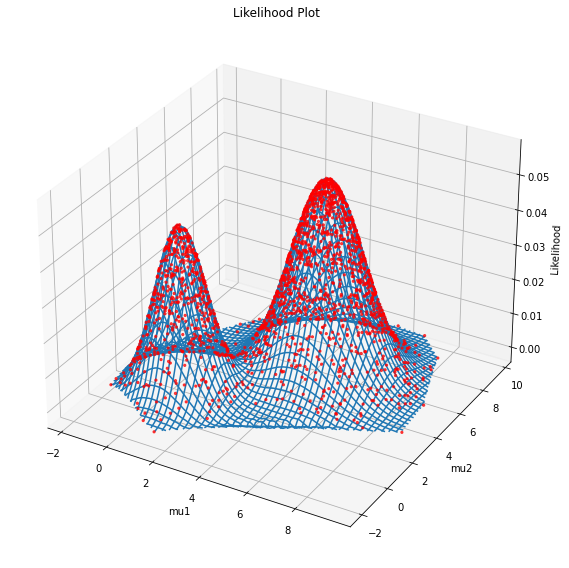

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from GMM_Likelihoods_1 import GaussianMixtureModel
# Define the Gaussian Mixture Model with 2 dimensions and 2 components
dimensions = 2
components = 2

gmm1 = GaussianMixtureModel(n_dimensions = dimensions, 
                            n_components = components, 
                           means = [[1, 1], [5, 5]], 
                           covs = [[[1, 0], [0, 1]], 
                                 [[2, 0], [0, 2]]], 
                           weights = [0.3, 0.7])

# Initialize the Gaussian Mixture Model class with n samples
n_samples = 2000
noise = 0.2
X1, noisy_data1 = gmm1.generate_data(n_samples, noise_scale = noise)

# Plot the data X
gmm1.plot_scatter(X1)
gmm1.plot_scatter(noisy_data1)

# Plot the histograms of data X
gmm1.plot_histograms(X1,noise_scale=noise)

# Calculate pdf of the data X 
prob1 = gmm1.pdf(noisy_data1)

# Calculate log-likelihoods of data X
log_likelihood1 = gmm1.calculate_log_likelihoods(noisy_data1)

# Plot the likelihoods of data X
gmm1.plot_log_likelihood(noisy_data1, prob1)

## Fitting the target distribution defined above with the Monte Carlo Algorithm.  

### Metropolis-Hasting Algorithm with difference proposal distribution

In [2]:
from MCMC_DianZhang.Dian_MCMC.MetropolisHastingMCMC.MHMC import MHMC
from MCMC_DianZhang.Dian_MCMC.MetropolisHastingMCMC.ProposalDistributions import UniformProposalDistribution, GausianProposalDistribution

U_proposal = UniformProposalDistribution(radius=0.3, Dim=2)
MHMC_fitter = MHMC(rho=gmm1.pdf)
X_MCMC = MHMC_fitter.generate(theta0=[0,1], qProb=U_proposal.qProb, qSamp=U_proposal.qSample, steps=6000)[0]

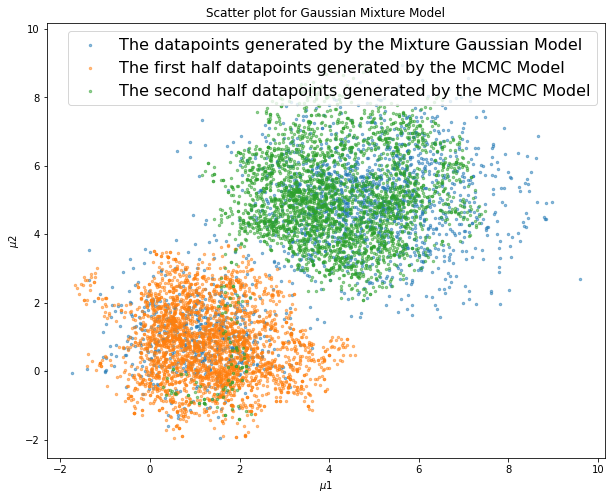

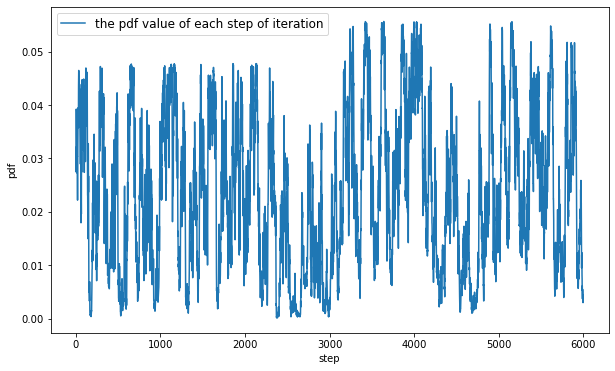

In [3]:
from MCMC_DianZhang.Dian_MCMC.Statistic_tools import targetDis_step_plot

Xs = [X1, np.asarray(X_MCMC[:3000]), np.asarray(X_MCMC[3000:])]
gmm1.plot_scatters(
    Xs=Xs, 
    labels=["The datapoints generated by the Mixture Gaussian Model", "The first half datapoints generated by the MCMC Model", "The second half datapoints generated by the MCMC Model"],
    figsize=(10, 8)
    )

targetDis_step_plot(thetas=X_MCMC, rho=gmm1.pdf, target_type="pdf", figsize=(10, 6))